In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits')
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')

In [12]:
ww405 = wcs.WCS(fh_405['SCI'].header)
ww410 = wcs.WCS(fh_410['SCI'].header)

Set OBSGEO-B to   -20.696577 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526819554.727 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [13]:
instrument = fh_405[0].header['INSTRUME']
telescope = fh_405[0].header['TELESCOP']
filt405 = fh_405[0].header['PUPIL']
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt405}')
filt410 = fh_410[0].header['FILTER']
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt410}')

In [14]:
filt405, filt410

('F405N', 'F410M')

In [15]:
waves_410 = wavelength_table_410['Wavelength']
trans_405 = np.interp(waves_410, wavelength_table_405['Wavelength'], wavelength_table_405['Transmission'])
trans_410 = wavelength_table_410['Transmission']

Text(0.5, 0, 'Wavelength [Angstroms]')

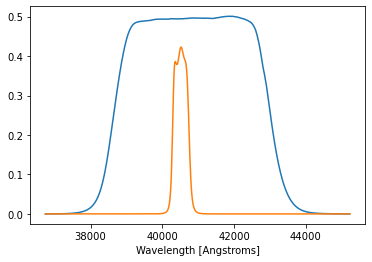

In [16]:
pl.plot(waves_410, trans_410)
pl.plot(waves_410, trans_405)
pl.xlabel("Wavelength [Angstroms]")

In [17]:
fractional_bandwidth_405 = ( (trans_410/trans_410.max()) * (trans_405/trans_405.max()) ).sum() / (trans_410/trans_410.max()).sum()

In [18]:
data_405_proj_410 = reproject.reproject_exact(fh_405['SCI'], fh_410['SCI'].header)

In [19]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410[0]*fractional_bandwidth_405
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_nrca.fits', overwrite=True)

In [20]:
bra_minus_cont = data_405_proj_410[0] - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_nrca.fits', overwrite=True)

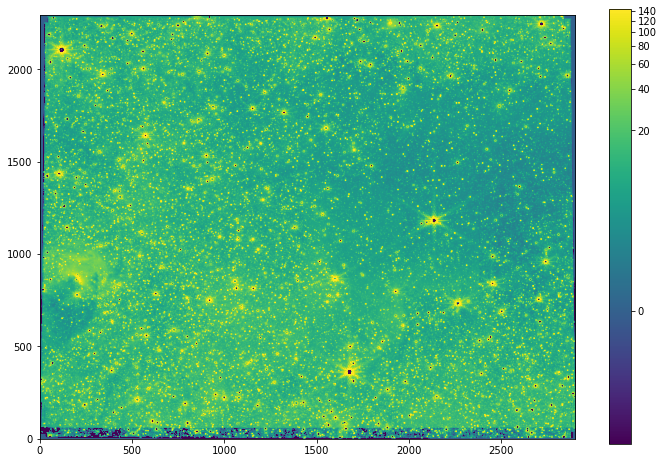

In [21]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

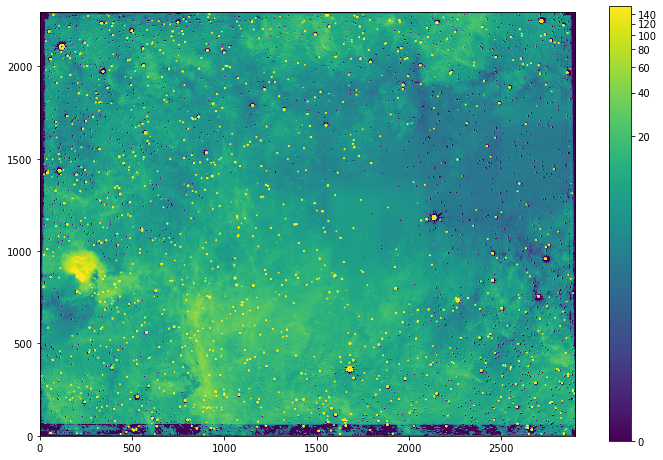

In [22]:
pl.figure(figsize=(12,8))
pl.imshow(bra_minus_cont, norm=simple_norm(bra_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [23]:
stars_bra = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_405['SCI'].data)
stars_bra['skycoord'] = ww405.pixel_to_world(stars_bra['xcentroid'], stars_bra['ycentroid'])
len(stars_bra)

10827

In [24]:
stars_410 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_410['SCI'].data)
stars_410['skycoord'] = ww410.pixel_to_world(stars_410['xcentroid'], stars_410['ycentroid'])
len(stars_410)

46269

In [25]:
matches, sep, _ = stars_bra['skycoord'].match_to_catalog_sky(stars_410['skycoord'], nthneighbor=1)

for cn in stars_bra.colnames:
    stars_bra.rename_column(cn, f"{cn}_405")
for cn in stars_410.colnames:
    stars_410.rename_column(cn, f"{cn}_410")
                         
stars_bra.add_column(name="sep_410_405", col=sep)
stars_bra.add_column(name="id_410_405", col=matches)
mergetbl = table.hstack([stars_bra, stars_410[matches]], join_type='exact')

(array([9.628e+03, 8.160e+02, 2.180e+02, 1.140e+02, 3.500e+01, 1.000e+01,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.30631914e-04, 1.58951806e-01, 3.17572981e-01, 4.76194155e-01,
        6.34815329e-01, 7.93436504e-01, 9.52057678e-01, 1.11067885e+00,
        1.26930003e+00, 1.42792120e+00, 1.58654238e+00]),
 <BarContainer object of 10 artists>)

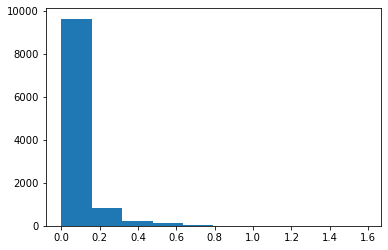

In [26]:
pl.hist(mergetbl['sep_410_405'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

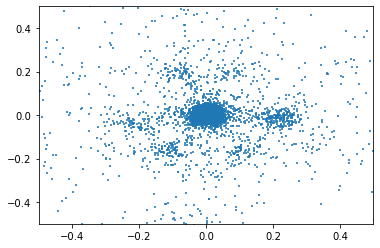

In [27]:
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

(-0.05, 0.05, -0.05, 0.05)

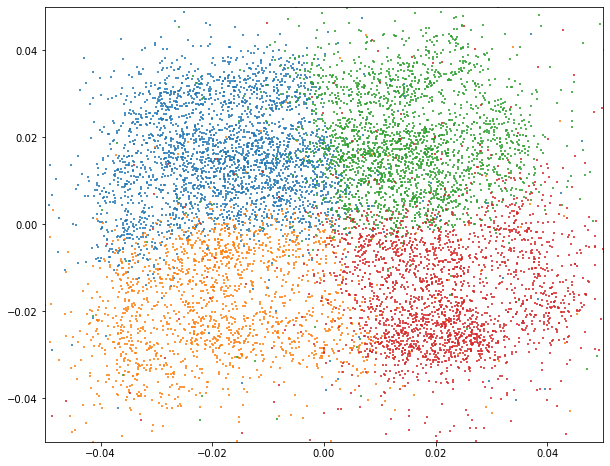

In [28]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])

In [29]:
mergetbl['xcentroid_405'].max(), mergetbl['ycentroid_405'].max()

(2894.514594482662, 2289.469433160902)

In [30]:
dist_from_center = ((mergetbl['xcentroid_405'] - 1450)**2 + (mergetbl['ycentroid_405'] - 1145)**2)**0.5

(0.0, 0.07)

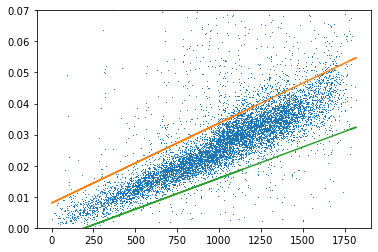

In [31]:
pl.plot(dist_from_center, mergetbl['sep_410_405'].to(u.arcsec).value, ',')
pl.plot(dist_from_center, dist_from_center/1750 * 0.045 + 0.008)
pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.07)

# The distortion is nearly linear!

In [32]:
ok = (mergetbl['sep_410_405'] < 0.05*u.arcsec) & (mergetbl['sep_410_405'] < (dist_from_center/1750*0.045 +0.08) *u.arcsec) & (mergetbl['sep_410_405'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)

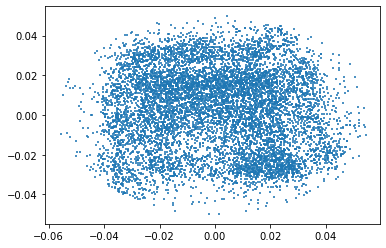

In [33]:
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.8)

In [34]:
from astropy.wcs.utils import fit_wcs_from_points

In [35]:
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=1)

In [36]:
ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_405'][ok], sip_degree=3)

In [37]:
skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])

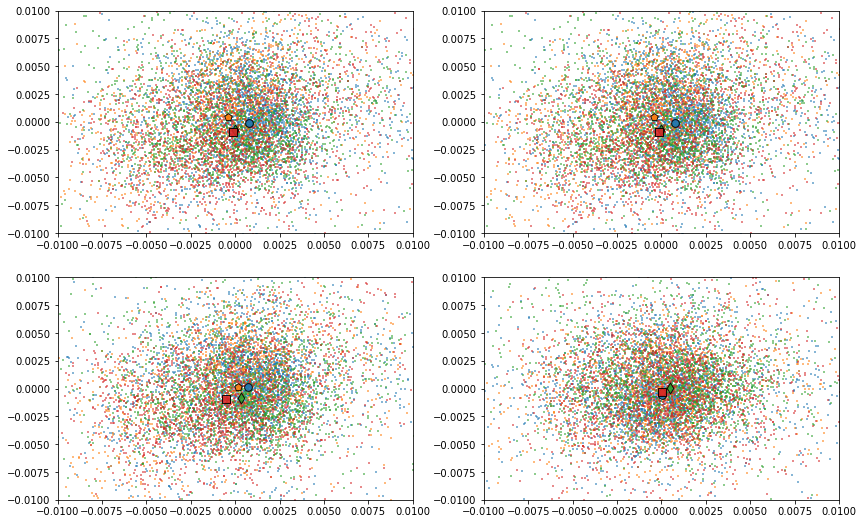

In [38]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_405'][ok], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_405'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_405'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_410'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_405'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_405'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_405'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

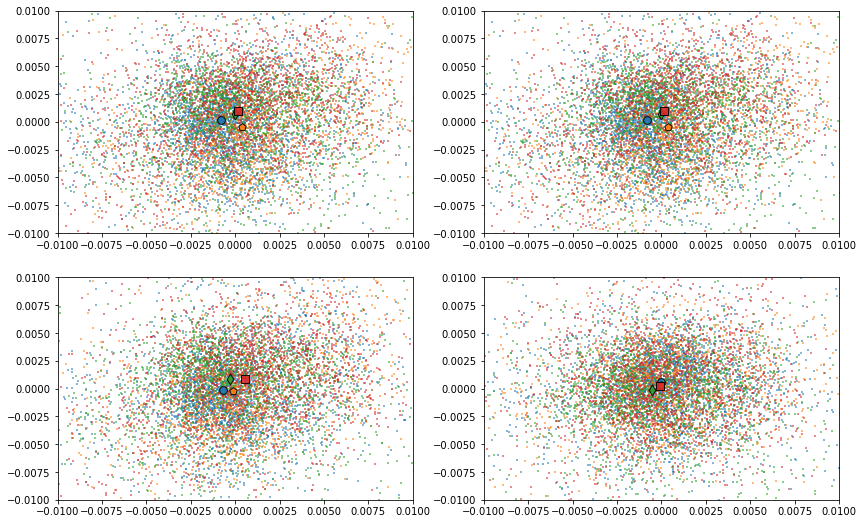

In [39]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
    skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_405'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [40]:
sip_degree = 3
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_405'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5

In [41]:
ww_405_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f405n_nrca_refitted_to_f410m.hdr', overwrite=True)

In [42]:
data_405_proj_410_refit, overlap_refit = reproject.reproject_exact((fh_405['SCI'].data, ww_405_refit), fh_410['SCI'].header)

Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [43]:
fits.PrimaryHDU(data=data_405_proj_410_refit, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_refitted405wcsto410_nrca.fits', overwrite=True)

In [44]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410_refit*fractional_bandwidth_405
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_nrca.fits', overwrite=True)

In [45]:
bra_minus_cont = data_405_proj_410_refit - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits', overwrite=True)

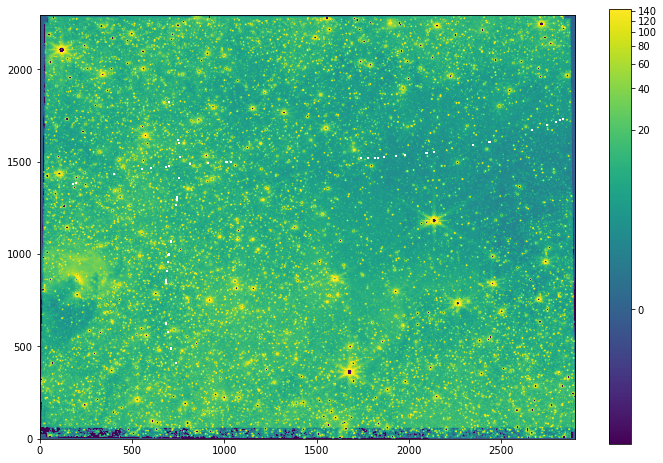

In [46]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

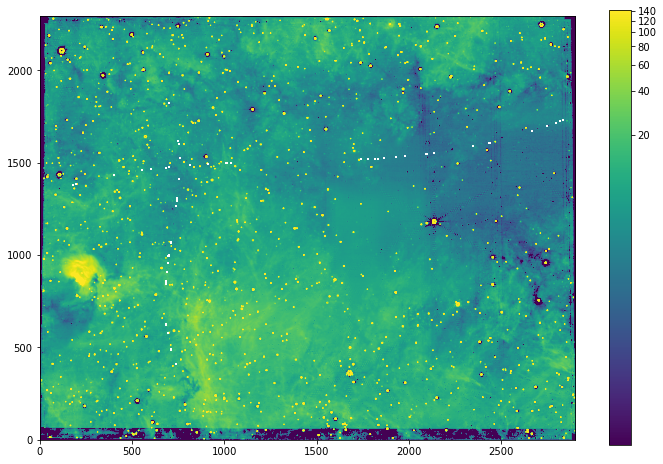

In [47]:
pl.figure(figsize=(12,8))
pl.imshow(bra_minus_cont, norm=simple_norm(bra_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

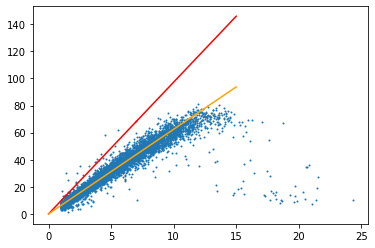

In [48]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_405'][ok], mergetbl['flux_410'][ok], s=1)
pl.plot(xr, xr/fractional_bandwidth_405, color='red')
scalefactor = 0.16
pl.plot(xr, xr/scalefactor, color='orange')

In [49]:
np.median(1/(mergetbl['flux_410'][ok]/mergetbl['flux_405'][ok]))

0.15911117054025

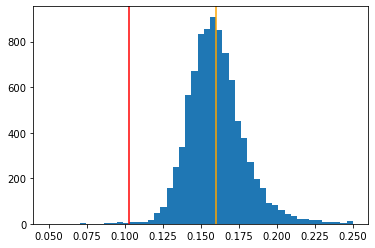

In [50]:
pl.hist(1/(mergetbl['flux_410'][ok]/mergetbl['flux_405'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(fractional_bandwidth_405, color='red')

In [51]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410_refit*scalefactor
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_nrca.fits', overwrite=True)

In [52]:
bra_minus_cont = data_405_proj_410_refit - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits', overwrite=True)